<a href="https://colab.research.google.com/github/joacorapela/svGPFA_IBL/blob/master/code/scripts/svGPFA_IBL_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for my very crude attempt on svGPFA on IBL data. Daniel 26/01/23 6.49pm

In [ ]:
# packages
!pip install ONE-api
!git clone -b master https://github.com/joacorapela/svGPFA.git
%pip install git+file:///content/svGPFA
%cd svGPFA/docs/ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'svGPFA' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning file:///content/svGPFA to /tmp/pip-req-build-ty9ukewg
  Running command git clone --filter=blob:none --quiet file:///content/svGPFA /tmp/pip-req-build-ty9ukewg
  Resolved file:///content/svGPFA to commit ef55b45b93342cef0869e808751566d255156ce4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
/content/svGPFA/docs/ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from one.api import ONE

import time
import warnings
import torch
import pickle
import copy
from tqdm import tqdm

import svGPFA.stats.kernels
import svGPFA.stats.svGPFAModelFactory
import svGPFA.stats.svEM
import svGPFA.utils.miscUtils
import svGPFA.utils.initUtils
import gcnu_common.stats.pointProcesses.tests    

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)

eID = 'ebe2efe3-e8a1-451a-8947-76ef42427cc9'
spikes = one.load_object(eID, 'spikes', 'alf/probe00/pykilosort')
trials = one.load_object(eID, 'trials')

n_neurons = len(np.unique(spikes['clusters']))
n_trials = len(trials['stimOn_times'])

# Raster plot of neuron #41 (WS1)

In [ ]:
# Our main interest is in spikes.times - the time of each recorded action potential ; spikes.clusters - the neuron each action potential was
# assigned to ; trials.stimOn_times - the time of stimulus onset on each trial ; and trials.choice - which gives the subject's choice on that trial
# (-1 or +1). All times are in seconds. We are going to make a raster of the spikes for neuron #41, so we start by getting the times of these spikes:

# Write some code that:
# 1. finds all spikes that occur between 100 ms before and 1s after a stimulus onset
# 2. plots these in a scatter plot, with time relative to stimulus onset on the x-axis and trial number on the y-axis
# 3. colors each spike by the choice made by the subject on that trial.

neuron41_spike_times = spikes.times[spikes.clusters==41]

scatter_xs = []
scatter_ys = []
extracted_subjects = []

for i, trial_time in enumerate(trials['stimOn_times']):

  if np.isnan(trial_time):
    continue

  else:
    start_idx = np.searchsorted(neuron41_spike_times, trial_time - 0.1)
    end_idx = np.searchsorted(neuron41_spike_times, trial_time + 1)

    for j in range(start_idx, end_idx):
      
      scatter_xs.append(neuron41_spike_times[j] - trial_time) # elapsed time after trial
      scatter_ys.append(i)
      extracted_subjects.append(trials['choice'][i])

assert len(extracted_subjects) == len(scatter_xs)
assert len(scatter_xs) == len(scatter_ys)

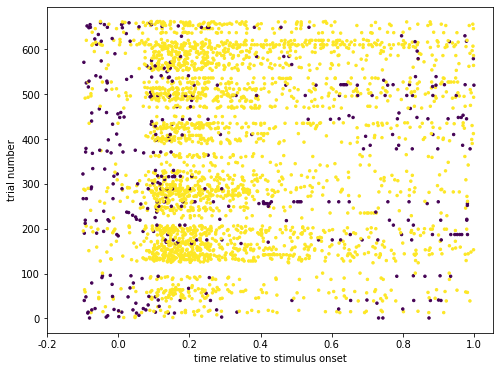

In [ ]:
# make raster plot
plt.figure(figsize=(8,6))
plt.scatter(scatter_xs, scatter_ys, c=extracted_subjects, s=6.0)
plt.xticks(np.linspace(-0.2, 1.0, 7), ['-0.2','0.0','0.2','0.4','0.6','0.8','1.0'])
plt.xlabel('time relative to stimulus onset')
plt.ylabel('trial number')
plt.show()

# Sparse variational GPFA

With default params. ELBO explodes to infinity.
<br>
Ideas: 1. run on first 10 trials; 2. reduce the number of inducing points?
<br>
Question: I didn't look closely on the codes in the package. Could you explain why the EM free energy lower bound shown here could be positive?

In [ ]:
# make a list of spikes
# takes  6 mins. There's probably a more computationally efficient way to do this ;)
spikes_times = [] # _spikes_times[r][n] should contain a list of spikes times of neuron n in trial r.

trials_start_time = 0.0
trials_end_time = 1.0

for r, trial_time in tqdm(enumerate(trials['stimOn_times'])):
  
  curr_trial_neuron_spikes_times = [] # len = n_neurons
  if np.isnan(trial_time):
    continue
  else:
    start_idx = np.searchsorted(spikes['times'], trial_time + trials_start_time)
    end_idx = np.searchsorted(spikes['times'], trial_time + trials_end_time)

    curr_trial_all_spikes = spikes['times'][start_idx:end_idx] # slice out all spikes within interval
    
    for n in range(n_neurons):
      curr_trial_neuron_spikes_times.append(torch.Tensor(curr_trial_all_spikes[(spikes.clusters==n)[start_idx:end_idx]]))

  spikes_times.append(curr_trial_neuron_spikes_times)

# assert n_trials == len(spikes_times) # some trial times are nan for some reason
n_trials = len(spikes_times)
assert n_neurons == len(spikes_times[0])

_spikes_times = copy.copy(spikes_times)

672it [08:06,  1.38it/s]


In [ ]:
# run svGPFA on a few trials
n_trials = 15
spikes_times = [_spikes_times[r] for r in range(n_trials)]


In [ ]:
n_latents = 2 # is it enough?
em_max_iter = 10
trials_start_times = [trials_start_time] * n_trials
trials_end_times = [trials_end_time] * n_trials

In [ ]:
# build default parameter specificiations                                                                                                                                              
default_params_spec = svGPFA.utils.initUtils.getDefaultParamsDict(
    n_neurons=n_neurons, n_trials=n_trials, n_latents=n_latents,
    em_max_iter=em_max_iter)
# get parameters and kernels types from the parameters specification
params, kernels_types = svGPFA.utils.initUtils.getParamsAndKernelsTypes(
    n_trials=n_trials, n_neurons=n_neurons, n_latents=n_latents,
    trials_start_times=trials_start_times, trials_end_times=trials_end_times,
    default_params_spec=default_params_spec)

Extracted default_params_spec[optim_params][n_quad]=200
Extracted default_params_spec[ind_points_locs_params0][n_ind_points]=[10, 10]
Extracted from default c0_distribution=Normal, c0_loc=0.0, c0_scale=1.0, c0_random_seed=None
Extracted from default d0_distribution=Normal, d0_loc=0.0, d0_scale=1.0, d0_random_seed=None
Extracted from default k_type=exponentialQuadratic and k_lengthsales0=1.0
Extracted from default ind_points_locs0_layout=equidistant
Extracted from default variational_mean0
Extracted from default variational_cov0
Extracted default_params_spec[optim_params][n_quad]=200
Extracted default_params_spec[optim_params][prior_cov_reg_param]=0.001
Extracted default_params_spec[optim_params][optim_method]=ecm
Extracted default_params_spec[optim_params][em_max_iter]=10
Extracted default_params_spec[optim_params][verbose]=True
Extracted default_params_spec[optim_params][estep_estimate]=True
Extracted default_params_spec[optim_params][estep_max_iter]=20
Extracted default_params_spec[o

In [ ]:
# build kernels
kernels_params0 = params["initial_params"]["posterior_on_latents"]["kernels_matrices_store"]["kernels_params0"]
kernels = svGPFA.utils.miscUtils.buildKernels(
    kernels_types=kernels_types, kernels_params=kernels_params0)

# create model
model = svGPFA.stats.svGPFAModelFactory.SVGPFAModelFactory.\
    buildModelPyTorch(kernels=kernels)

# set initial parameters
model.setParamsAndData(
    measurements=spikes_times,
    initial_params=params["initial_params"],
    eLLCalculationParams=params["ell_calculation_params"],
    priorCovRegParam=params["optim_params"]["prior_cov_reg_param"])

In [ ]:
svEM = svGPFA.stats.svEM.SVEM_PyTorch()
tic = time.perf_counter()
lowerBoundHist, elapsedTimeHist, terminationInfo, iterationsModelParams = \
    svEM.maximize(model=model, optim_params=params["optim_params"],
                  method=params["optim_params"]["optim_method"])
toc = time.perf_counter()
print(f"Elapsed time {toc - tic:0.4f} seconds")

Iteration 01, estep start: -inf
Iteration 01, estep end: -7497.461822, niter: 20, nfeval: 24
Iteration 01, mstep_embedding start: -7497.461822
Iteration 01, mstep_embedding end: 31411.673852, niter: 20, nfeval: 25
Iteration 01, mstep_kernels start: 31411.673852
Iteration 01, mstep_kernels end: 34068.712957, niter: 11, nfeval: 16
Iteration 01, mstep_indpointslocs start: 34068.712957
Iteration 01, mstep_indpointslocs end: 34651.570478, niter: 20, nfeval: 25
Iteration 02, estep start: 34651.570478
Iteration 02, estep end: nan, niter: 6, nfeval: 36
Iteration 02, mstep_embedding start: nan
Iteration 02, mstep_embedding end: nan, niter: 1, nfeval: 27
Iteration 02, mstep_kernels start: nan


_LinAlgError: ignored

In [ ]:
# plot free energy history
import svGPFA.plot.plotUtilsPlotly
fig = svGPFA.plot.plotUtilsPlotly.getPlotLowerBoundHist(lowerBoundHist=lowerBoundHist)
fig.show()

NameError: ignored

In [ ]:
neuron_to_plot = 0
latent_to_plot = 0
n_time_steps_CIF = 100
trials_colorscale = "hot"

# set times to plot
trials_start_times = [trials_start_time for r in range(n_trials)]
trials_end_times = [trials_end_time for r in range(n_trials)]
trials_times = svGPFA.utils.miscUtils.getTrialsTimes(
    start_times=trials_start_times,
    end_times=trials_end_times,
    n_steps=n_time_steps_CIF)

# set trials colors
trials_colors = px.colors.sample_colorscale(
    colorscale=trials_colorscale, samplepoints=n_trials,
    colortype="rgb")
trials_colors_patterns = [f"rgba{trial_color[3:-1]}, {{:f}})" for trial_color in trials_colors]

# set trials labels
trials_labels = [str(r) for r in range(n_trials)]

In [ ]:
# plot estimated latent across trials
test_mu_k, test_var_k = model.predictLatents(times=trials_times)
fig = svGPFA.plot.plotUtilsPlotly.getPlotLatentAcrossTrials(times=trials_times.numpy(), latentsMeans=test_mu_k, latentsSTDs=torch.sqrt(test_var_k), latentToPlot=latent_to_plot, trials_colors_patterns=trials_colors_patterns, xlabel="Time (msec)")
fig.show()

In [ ]:
embedding_means, embedding_vars = model.predictEmbedding(times=trials_times)
embedding_means = embedding_means.detach().numpy()
embedding_vars = embedding_vars.detach().numpy()
title = "Neuron {:d}".format(neuron_to_plot)
fig = svGPFA.plot.plotUtilsPlotly.getPlotEmbeddingAcrossTrials(times=trials_times.numpy(), embeddingsMeans=embedding_means[:,:,neuron_to_plot], embeddingsSTDs=np.sqrt(embedding_vars[:,:,neuron_to_plot]), trials_colors_patterns=trials_colors_patterns, title=title)
fig.show()

In [ ]:
with torch.no_grad():
    ePos_CIF_values = model.computeExpectedPosteriorCIFs(times=trials_times)
fig = svGPFA.plot.plotUtilsPlotly.getPlotCIFsOneNeuronAllTrials(trials_times=trials_times, cif_values=ePos_CIF_values, neuron_index=neuron_to_plot, trials_colors=trials_colors)                                                                                                                                      
fig.show()

In [ ]:
kernelsParams = [kernel_param.detach().numpy() for kernel_param in model.getKernelsParams()]
kernelsTypes = [type(kernel).__name__ for kernel in model.getKernels()]
fig = svGPFA.plot.plotUtilsPlotly.getPlotKernelsParams(
    kernelsTypes=kernelsTypes, kernelsParams=kernelsParams)
fig.show()